### Political Alignment and Attitudes Toward CCTV Surveillance

In [175]:
import pandas as pd
from scipy.stats import chi2_contingency
import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [176]:
df = preprocessing.preprocessed_data('data')

In [177]:
df.columns

Index(['ResponseId_Response ID',
       'Q0_Do you live in or frequently visit the city of Groningen?',
       'Q1_How many CCTV cameras for surveillance do you think the municipality of Groningen currently owns?',
       'Q2_Do you think the municipality currently uses AI  (for example for facial recognition or automated crime detection) with CCTV surveillance cameras?',
       'Q3_Do you think the municipality should use AI with its CCTV surveillance system?',
       'Q4_Do you think there should be more or fewer CCTV surveillance cameras in the city centre of Groningen?',
       'Q5_To what extent are you concerned about privacy related to CCTV surveillance cameras in Groningen?',
       'Q6_Do you think CCTV surveillance cameras help improve safety in the city centre?',
       'Q7_Do you feel safer knowing there are CCTV surveillance cameras installed when traveling outside?',
       'Q8_Do you know how the data collected from the CCTV surveillance cameras is stored?',
       'Q9_A

In [178]:
# Define mapping
party_map = {
    'GroenLinks - PVDA': 'Left',
    'SP': 'Left',
    'Partij voor de Dieren': 'Left',
    
    'D66': 'Center',
    'Volt': 'Center',
    'ChristenUnie': 'Center',
    'CDA': 'Center',
    'Student & Stad': 'Center',  
    
    'VVD': 'Right',
    'PVV': 'Right',
    'Ja21': 'Right',
    'SGP': 'Right',
    'BBB': 'Right',
    'NSC': 'Right',

    'Piratenpartij - De Groenen': 'Other',
    '50PLUS': 'Other',
    'prefer not to say': 'Other',
    'other': 'Other'
}

# Apply grouping
df['PoliticalGroup'] = df['Q10_Which political party do you most align with? (Optional)'].map(party_map)


In [179]:
unmapped = df[df['PoliticalGroup'].isna()]['Q10_Which political party do you most align with? (Optional)'].unique()
print("Unmapped parties:", unmapped)

Unmapped parties: [nan]


In [180]:
df['PoliticalGroup'] = df['PoliticalGroup'].fillna('Other')

In [181]:
print(df['PoliticalGroup'].value_counts(dropna=False))

PoliticalGroup
Left      84
Other     68
Center    50
Right     38
Name: count, dtype: int64


In [182]:
survey_questions = [
    'Q2_Do you think the municipality currently uses AI  (for example for facial recognition or automated crime detection) with CCTV surveillance cameras?',
    'Q3_Do you think the municipality should use AI with its CCTV surveillance system?',
    'Q4_Do you think there should be more or fewer CCTV surveillance cameras in the city centre of Groningen?',
    'Q5_To what extent are you concerned about privacy related to CCTV surveillance cameras in Groningen?',
    'Q6_Do you think CCTV surveillance cameras help improve safety in the city centre?',
    'Q7_Do you feel safer knowing there are CCTV surveillance cameras installed when traveling outside?',
    'Q8_Do you know how the data collected from the CCTV surveillance cameras is stored?'
]

# Run chi-square test for each question
for question in survey_questions:
    print(f"--- Chi-square test for {question} ---")
    contingency = pd.crosstab(df['PoliticalGroup'], df[question])
    
    # Only run test if there are enough non-empty cells
    if contingency.shape[0] >= 2 and contingency.shape[1] >= 2:
        chi2, p, dof, expected = chi2_contingency(contingency)
        print(f"Chi² = {chi2:.2f}, df = {dof}, p-value = {p:.4f}")
        if p < 0.05:
            print("→ Significant association found.")
        else:
            print("→ No significant association.")
    else:
        print("→ Not enough data to run test.")
    
    print()

--- Chi-square test for Q2_Do you think the municipality currently uses AI  (for example for facial recognition or automated crime detection) with CCTV surveillance cameras? ---
Chi² = 16.23, df = 12, p-value = 0.1807
→ No significant association.

--- Chi-square test for Q3_Do you think the municipality should use AI with its CCTV surveillance system? ---
Chi² = 11.14, df = 12, p-value = 0.5174
→ No significant association.

--- Chi-square test for Q4_Do you think there should be more or fewer CCTV surveillance cameras in the city centre of Groningen? ---
Chi² = 20.67, df = 15, p-value = 0.1477
→ No significant association.

--- Chi-square test for Q5_To what extent are you concerned about privacy related to CCTV surveillance cameras in Groningen? ---
Chi² = 19.13, df = 12, p-value = 0.0855
→ No significant association.

--- Chi-square test for Q6_Do you think CCTV surveillance cameras help improve safety in the city centre? ---
Chi² = 23.50, df = 12, p-value = 0.0238
→ Significant as

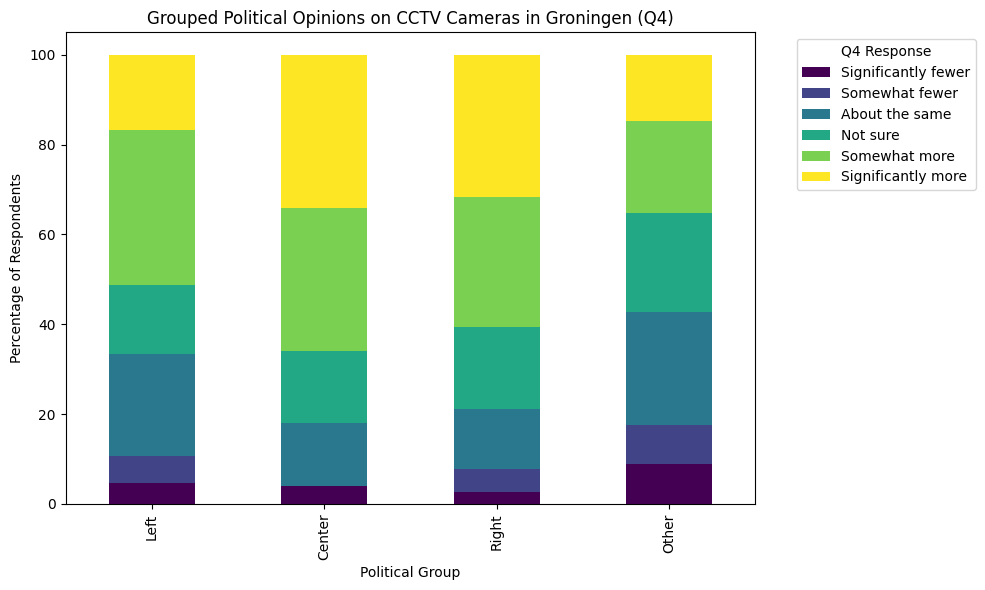

In [183]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

viz_df = df[['PoliticalGroup',
             'Q4_Do you think there should be more or fewer CCTV surveillance cameras in the city centre of Groningen?']].dropna()

viz_df = viz_df.rename(columns={
    'Q4_Do you think there should be more or fewer CCTV surveillance cameras in the city centre of Groningen?': 'Q4'
})

ordered_q4 = [
    'Significantly fewer',
    'Somewhat fewer',
    'About the same',
    'Not sure',
    'Somewhat more',
    'Significantly more'
]
viz_df['Q4'] = pd.Categorical(viz_df['Q4'], categories=ordered_q4, ordered=True)

# Create normalized count data
count_data = pd.crosstab(viz_df['PoliticalGroup'], viz_df['Q4'], normalize='index') * 100
count_data = count_data[ordered_q4]  # Ensure correct order

group_order = ['Left', 'Center', 'Right', 'Other']

count_data = count_data.reindex(group_order)

# Plot
count_data.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))

plt.title("Grouped Political Opinions on CCTV Cameras in Groningen (Q4)")
plt.xlabel("Political Group")
plt.ylabel("Percentage of Respondents")
plt.legend(title="Q4 Response", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [184]:
q6_map = {
    'Yes, definitely': 1,
    'Probably': 2,
    'Probably not': 3,
    'No, definitely not': 4,
    "I don't know": None  
}
df['Q6_ordinal'] = df['Q6_Do you think CCTV surveillance cameras help improve safety in the city centre?'].map(q6_map)

# Drop missing values in relevant columns
analysis_df = df[['Q6_ordinal', 'PoliticalGroup']].dropna()

In [185]:
# 2. Cross-tabulation
crosstab = pd.crosstab(df['PoliticalGroup'], df['Q6_Do you think CCTV surveillance cameras help improve safety in the city centre?'])
print("Cross-tabulation:\n", crosstab)

Cross-tabulation:
 Q6_Do you think CCTV surveillance cameras help improve safety in the city centre?  I don’t know  \
PoliticalGroup                                                                                    
Center                                                                                        1   
Left                                                                                          4   
Other                                                                                         1   
Right                                                                                         0   

Q6_Do you think CCTV surveillance cameras help improve safety in the city centre?  No, definitely not  \
PoliticalGroup                                                                                          
Center                                                                                              0   
Left                                                                   

In [186]:
# Chi-square test
chi2, p, dof, expected = chi2_contingency(crosstab)
print(f"\nChi-square test:\nChi² = {chi2:.2f}, df = {dof}, p-value = {p:.4f}")


Chi-square test:
Chi² = 23.50, df = 12, p-value = 0.0238


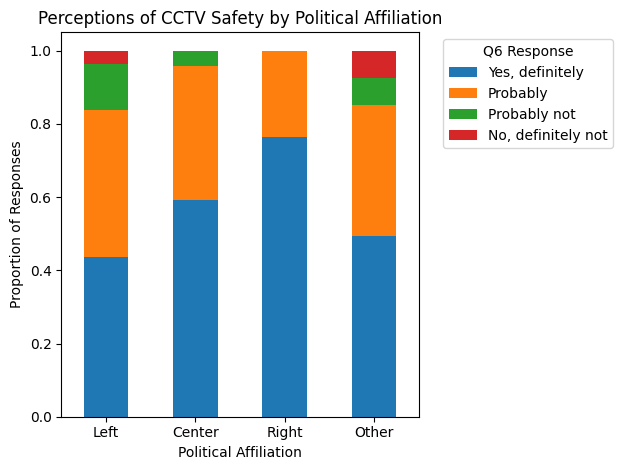

In [187]:
q6_order = ['Yes, definitely', 'Probably', 'Probably not', 'No, definitely not']

political_order = ['Left', 'Center', 'Right', 'Other']

crosstab = crosstab.reindex(index=political_order, columns=q6_order)

crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0)

# Plot
crosstab_norm.plot(kind='bar', stacked=True)
plt.title('Perceptions of CCTV Safety by Political Affiliation')
plt.xlabel('Political Affiliation')
plt.ylabel('Proportion of Responses')
plt.legend(title='Q6 Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [188]:
# Ordinal Logistic Regression
# Define the model
model = OrderedModel(
    analysis_df['Q6_ordinal'],
    pd.get_dummies(analysis_df['PoliticalGroup'], drop_first=True),  # Use Left as baseline
    distr='logit'
)

# Fit the model
res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.973361
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26
                             OrderedModel Results                             
Dep. Variable:             Q6_ordinal   Log-Likelihood:                -227.77
Model:                   OrderedModel   AIC:                             467.5
Method:            Maximum Likelihood   BIC:                             488.3
Date:                Mon, 19 May 2025                                         
Time:                        14:12:31                                         
No. Observations:                 234                                         
Df Residuals:                     228                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------